In this notebook, I will introduce how to use function `collect_gradient` to extract the gradient. 

    """
    This function will return 

    grad: np.array gradients 
    true_domain: np.array true domain 
    idx_class: np.array true class
    true_group: np.array true subgroup
    idx_mode: np.array the mode of the samples ('train' or 'val')

    And will also save the numpy.array above into folder '%s/privateDemographics/results/%s' % (root_dir, dataset_name)

    Parameters
    -----------
    model: the name of the models. Please refer the possible choices of model in settings.py. 
            Actually, this parameter doesn't matter that much. 
    m: the model. 
    loader: dict: {
        'train': data loader,
        'val': data loader,
        'test': data loader,
    },
    device: torch.device('cpu') or torch.device('cuda')
    optim: torch.optimizer
    num_domain: the number of domains
    num_group: the number of groups (number of classes * number of domain)
    task: 'fairness' or 'irm', always set as 'fairness'
    lr_scheduler: set it as None unless you are using Bert
    dataset_name: select the folder to save the results
    num_class: the number of class
    --------------
    """

Step 1: Go to my ccc folder, go to 'privateDemographics'

Step 2: use `git pull master` to sync (There might be some issues... please discard the local changes I had in ccc)

Step 3: create a file named root_dir.py, and add a line: root_dir = '/dccstore/storage'

Step 4: conda activate balancinggroups (maybe some additional packeges will be required)

Step 5: create a folder `trials`, and you can create new files there! (I have added this folder into .gitignore)

That's it! Here I provide an exmaple of using the function `collect_gradient`

In [1]:
import os, sys
os.chdir('../')
from methods import *
from datasets import toyData

In [128]:

def dbscan_results(grad, process_grad=0, outlier=0, use_val_group=0, metric = 'euclidean'):

    pred_domain = np.zeros(true_domain.shape)
    num_group = 0

    for y in range(num_class):
        idx_y = idx_class == y
        grad_y = grad[idx_class == y]
        if process_grad:
            center = grad_y.mean(axis=0)
            grad_y = grad_y - center
            grad_y = normalize(grad_y)

        best_ars = -np.inf
        best_ss = -np.inf
        

        for eps in np.linspace(0.1, 0.7, 13):
            for min_samples in [5, 10, 20, 30, 40, 50, 60, 100]:

                dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric) # , metric='cosine'
                dbscan.fit(grad_y)
                
                
                ars = ARS(true_domain[idx_y], dbscan.labels_)
                try:
                    ss = silhouette_score(grad_y, dbscan.labels_)
                except: 
                    ss = -1

                update_pred_domain = False
                if use_val_group:
                    if ars > best_ars:
                        update_pred_domain = True

                else:
                    if ss > best_ss:
                        update_pred_domain = True

                if update_pred_domain:
                    best_ars = ars
                    best_ss = ss

                    idx = idx_class == y
                    idx[idx] = dbscan.labels_ >= 0
                    pred_domain[idx] = dbscan.labels_[dbscan.labels_ >= 0] + num_group
                    # detect the outliers
                    idx = idx_class == y
                    idx[idx] = dbscan.labels_ < 0
                    pred_domain[idx] = -1
                    
                    best_params = {'eps': eps, 'min_samples': min_samples}
        print(ars, ss)

        num_group = len(np.unique(pred_domain)) - int(-1 in pred_domain)
        print("Number of group: %d" % num_group)
        print("Best parameter: ", best_params)

    ars_score = ARS(true_group, pred_domain)
    try:
        ss = silhouette_score(grad, pred_domain)
    except:
        ss = -1
    print("ARS: ", ars_score)
    print("SS: ", ss)
    return pred_domain, num_group

In [2]:
ARS([1,1,1,1,1,1,1,1,1,2,2,2,0], [1,1,1,1,1,1,2,2,2,2,2,2,0])

0.3076923076923077

In [3]:
def kmeans_results(inputs, use_val_group = 1):
    pred_domain = np.zeros(true_domain.shape)
    num_group = 0

    for y in range(2):
        idx_y = idx_class == y
        inputs_y = inputs[idx_y]
        best_ss, best_ars = -np.inf, -np.inf
        
        for n_clusters in range(2,10,2):
            kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(inputs_y)
            ars = ARS(true_domain[idx_y], kmeans.labels_)
            ss = silhouette_score(inputs_y, kmeans.labels_)
            update = False

            if use_val_group:
                if ars > best_ars:
                    update = True

            else:
                if ss > best_ss:
                    update = True

            if update:
                best_ars = ars
                best_ss = ss
                pred_domain[idx_y] = kmeans.labels_ + num_group

        num_group = len(np.unique(pred_domain)) - int(-1 in pred_domain)
        print("Number of group: %d" % num_group)

    ars = ARS(true_group, pred_domain)
    ss = silhouette_score(inputs, pred_domain)
    print("ARS: ", ars)
    print("SS: ", ss)
    return pred_domain, num_group

# Toy dataset (w/o outliers)

In [129]:
dataset_name = 'toy'

In [146]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    0,
    True,
    '/mnt/cloud/yzeng58/privateDemographics/models/toy/erm_num_epoch_100_batch_size_128_lr_0.01_subsample_0_weight_decay_0.0001_outlier_0_model_logreg_best.model',
    123,
    'grass',
    torch.device('cpu'),
    1e-3,
    1e-5,
    '',
)


Loading the toy dataset with outlier = 0!


In [147]:
grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 0,
)

Loaded all the gradient information into folder /mnt/cloud/yzeng58/privateDemographics/results/toy...


In [148]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    dataset_name,
    loader,
    device,
    m,
    num_domain,
    outlier = 0,
)

Loaded all the input information into folder /mnt/cloud/yzeng58/privateDemographics/results/toy...


In [150]:
_, _ = dbscan_results(grad, process_grad=1, outlier=0, use_val_group=0, metric = 'cosine')

0.0 -1
Number of group: 2
Best parameter:  {'eps': 0.25, 'min_samples': 30}
0.0 -1
Number of group: 4
Best parameter:  {'eps': 0.25, 'min_samples': 20}
ARS:  0.6966440200001294
SS:  0.5643024


In [151]:
_, _ = dbscan_results(grad, process_grad=0, outlier=0, use_val_group=0, metric = 'euclidean')

0.7068731811386562 0.69892865
Number of group: 1
Best parameter:  {'eps': 0.7, 'min_samples': 100}
0.6830485693803716 0.722774
Number of group: 2
Best parameter:  {'eps': 0.44999999999999996, 'min_samples': 40}
ARS:  0.7724033035163413
SS:  0.3843489


In [156]:
_, _ = dbscan_results(inputs, process_grad=0, outlier=0, use_val_group=0, metric = 'euclidean')

-0.004181181871991912 0.17610690112763216
Number of group: 2
Best parameter:  {'eps': 0.5499999999999999, 'min_samples': 50}
0.332921183540846 0.5719091922902078
Number of group: 3
Best parameter:  {'eps': 0.7, 'min_samples': 100}
ARS:  0.592309923279124
SS:  0.17036510670376573


In [152]:
_, _ = dbscan_results(inputs, process_grad=1, outlier=0, use_val_group=0, metric = 'cosine')

0.0 -1
Number of group: 2
Best parameter:  {'eps': 0.3, 'min_samples': 100}
0.0 -1
Number of group: 4
Best parameter:  {'eps': 0.2, 'min_samples': 40}
ARS:  0.5132519195124181
SS:  0.17234407291090542


In [153]:
_, _ = dbscan_results(inputs, process_grad=0, outlier=0, use_val_group=0, metric = 'euclidean')

-0.004181181871991912 0.17610690112763216
Number of group: 2
Best parameter:  {'eps': 0.5499999999999999, 'min_samples': 50}
0.332921183540846 0.5719091922902078
Number of group: 3
Best parameter:  {'eps': 0.7, 'min_samples': 100}
ARS:  0.592309923279124
SS:  0.17036510670376573


In [154]:
kmeans_results(inputs, use_val_group = 0)

Number of group: 2
Number of group: 4
ARS:  0.550487214885703
SS:  0.17740029780313202


(array([1., 1., 0., 2., 1., 2., 1., 3., 3., 3., 0., 1., 1., 1., 1., 1., 2.,
        1., 1., 3., 1., 1., 1., 0., 2., 3., 2., 0., 0., 0., 2., 0., 3., 1.,
        0., 2., 1., 1., 1., 2., 2., 1., 2., 1., 2., 2., 1., 3., 1., 1., 1.,
        3., 2., 3., 1., 1., 2., 1., 3., 1., 0., 3., 1., 0., 1., 2., 2., 2.,
        3., 1., 1., 0., 0., 1., 3., 2., 3., 3., 1., 2., 3., 1., 0., 3., 2.,
        1., 2., 3., 3., 0., 2., 3., 3., 0., 0., 3., 0., 3., 0., 3., 0., 3.,
        0., 0., 2., 3., 1., 2., 3., 0., 0., 2., 1., 3., 1., 3., 3., 3., 1.,
        3., 0., 2., 0., 0., 3., 1., 2., 0., 1., 0., 3., 3., 2., 3., 3., 2.,
        2., 1., 2., 3., 1., 0., 1., 0., 1., 2., 2., 0., 3., 0., 3., 1., 2.,
        2., 1., 2., 1., 0., 1., 2., 1., 0., 1., 1., 0., 3., 0., 0., 1., 3.,
        0., 0., 0., 3., 2., 1., 2., 1., 2., 1., 3., 1., 2., 1., 1., 2., 3.,
        1., 1., 0., 1., 0., 2., 2., 1., 0., 1., 2., 1., 1., 3., 2., 3., 3.,
        1., 2., 0., 1., 3., 0., 0., 2., 3., 1., 0., 3., 0., 0., 0., 1., 0.,
        3., 

In [155]:
kmeans_results(grad, use_val_group = 0)

Number of group: 2
Number of group: 4
ARS:  0.8409292726685735
SS:  0.60995096


(array([1., 1., 1., 2., 1., 2., 1., 2., 3., 3., 1., 1., 1., 1., 1., 1., 2.,
        1., 1., 2., 1., 1., 1., 0., 2., 3., 2., 1., 0., 1., 2., 1., 2., 1.,
        0., 2., 1., 1., 1., 2., 2., 1., 2., 1., 2., 2., 1., 3., 1., 1., 1.,
        3., 2., 3., 1., 1., 2., 1., 2., 1., 0., 2., 1., 0., 1., 2., 2., 2.,
        3., 1., 1., 0., 0., 1., 2., 2., 3., 3., 1., 2., 3., 1., 0., 2., 2.,
        1., 2., 3., 2., 1., 2., 3., 3., 0., 1., 3., 0., 3., 0., 3., 0., 3.,
        0., 0., 2., 3., 1., 2., 3., 1., 0., 2., 1., 2., 1., 2., 3., 3., 1.,
        2., 0., 2., 1., 0., 3., 1., 2., 1., 1., 0., 3., 2., 2., 2., 3., 2.,
        2., 1., 2., 3., 1., 0., 1., 0., 1., 2., 2., 1., 3., 0., 3., 1., 2.,
        2., 1., 2., 1., 1., 1., 2., 1., 0., 1., 1., 1., 2., 0., 0., 1., 2.,
        0., 1., 0., 3., 2., 1., 2., 1., 2., 1., 3., 1., 2., 1., 1., 2., 3.,
        1., 1., 0., 1., 1., 2., 2., 1., 0., 1., 2., 1., 1., 2., 2., 3., 3.,
        1., 2., 0., 1., 2., 1., 1., 2., 3., 1., 0., 3., 0., 1., 0., 1., 0.,
        3., 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
markers = ['o', 'x']
colors = [
    '#073B4C',
    '#FFD166',
    '#06D6A0',
    '#118AB2',
    '#DD3497',
]

for i in range(num_group):
    idx = pred_domain == i
    ax.scatter(df.x1[idx], df.x2[idx], color = colors[i])

# Toy dataset (w. outliers)

In [179]:
dataset_name = 'toy'

In [180]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    outlier = 1,
    load_representations = True,
    start_model_path = '/mnt/cloud/yzeng58/privateDemographics/models/toy/erm_num_epoch_100_batch_size_128_lr_0.01_subsample_0_weight_decay_0.0001_outlier_0_model_logreg_best.model',
    seed = 123,
    method = 'grass',
    device = torch.device('cpu'),
    lr = 1e-3,
    weight_decay = 1e-5,
    model = '',
)


Loading the toy dataset with outlier = 1!


In [181]:
grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 1
)

Computing the gradients...


Epoch: 2: 100%|██████████| 5/5 [00:00<00:00, 122.53it/s]


Saving all the gradient information into folder /mnt/cloud/yzeng58/privateDemographics/results/toy/outliers...
All the gradient information are saved in folder /mnt/cloud/yzeng58/privateDemographics/results/toy/outliers!


In [182]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    dataset_name,
    loader,
    device,
    m,
    num_domain,
    outlier = 1,
)

Loaded all the input information into folder /mnt/cloud/yzeng58/privateDemographics/results/toy/outliers...


In [183]:
pred_domain, num_group = dbscan_results(grad, process_grad=0, use_val_group=0, metric = 'euclidean')

0.6606199241088908 0.6973431
Number of group: 1
Best parameter:  {'eps': 0.7, 'min_samples': 100}
0.6158201914308734 0.7102526
Number of group: 2
Best parameter:  {'eps': 0.7, 'min_samples': 100}
ARS:  0.719389209850952
SS:  0.36866975


In [184]:
pred_domain, num_group = dbscan_results(grad, process_grad=1, use_val_group=0, metric = 'cosine')

0.0 -1
Number of group: 2
Best parameter:  {'eps': 0.35, 'min_samples': 60}
0.0 -1
Number of group: 4
Best parameter:  {'eps': 0.4, 'min_samples': 40}
ARS:  0.6886872861058603
SS:  0.56382746


In [185]:
pred_domain, num_group = dbscan_results(inputs, process_grad=0, use_val_group=0, metric = 'euclidean')

0.0 -1
Number of group: 3
Best parameter:  {'eps': 0.6, 'min_samples': 60}
0.29881449292661977 0.5336405107805244
Number of group: 4
Best parameter:  {'eps': 0.7, 'min_samples': 100}
ARS:  0.5936752764981138
SS:  0.14414751397553743


In [186]:
pred_domain, num_group = dbscan_results(inputs, process_grad=1, use_val_group=0, metric = 'cosine')

0.0 -1
Number of group: 2
Best parameter:  {'eps': 0.2, 'min_samples': 40}
0.0 -1
Number of group: 4
Best parameter:  {'eps': 0.2, 'min_samples': 50}
ARS:  0.5021512770536771
SS:  0.1536745232615489


In [187]:
pred_domain, num_group = dbscan_results(inputs, process_grad=0, outlier=0, use_val_group=0)

0.0 -1
Number of group: 3
Best parameter:  {'eps': 0.6, 'min_samples': 60}
0.29881449292661977 0.5336405107805244
Number of group: 4
Best parameter:  {'eps': 0.7, 'min_samples': 100}
ARS:  0.5936752764981138
SS:  0.14414751397553743


In [12]:
from utils import vis_3d_tsne_interactive
import plotly
from sklearn.manifold import TSNE

In [47]:
def vis_3d_tsne_interactive(
    dataset = 'waterbirds', 
    mode = 'true',
    outlier = 1,
    vis_group = None,
    vis_representation = 'grad',
    y = 1,
):
    n_components = 3
    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
    )
    if outlier:
        folder_name = '%s/privateDemographics/results/%s/outliers' % (root_dir, dataset)
    else:
        folder_name = '%s/privateDemographics/results/%s' % (root_dir, dataset)

    grad_tsne = {}
    file_name = '%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, y)
    try:
        print('Loading the TSNE results...')
        grad_tsne[dataset] = np.load(file_name,allow_pickle=True)    
    except:
        print('Performing TSNE dimension reduction...')
        grad = np.load('%s/%s.npy' % (folder_name, vis_representation),allow_pickle=True)
        grad_tsne[dataset] = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=3).fit_transform(grad) 
        with open('%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, 0), 'wb') as f:
            print('Saving the TSNE results...')
            np.save(f, grad_tsne[dataset][idx_class == 0])
        with open('%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, 1), 'wb') as f:
            print('Saving the TSNE results...')
            np.save(f, grad_tsne[dataset][idx_class == 1])
        grad_tsne[dataset] = grad_tsne[dataset][idx_class == y]

    if mode == 'true':
        true_group = np.load('%s/true_group.npy' % (folder_name))
        vis_group = true_group[idx_class == y]
    elif mode == 'pred':
        try:
            with open('%s/pred_dict_outlier_0.json' % (folder_name), 'r') as f:
                pred_dict = json.load(f)
        except:
            with open('%s/pred_dict.json' % (folder_name), 'r') as f:
                pred_dict = json.load(f)
        pred_group = pred_dict['train'] + pred_dict['val']
        vis_group = pred_group[idx_class == y]

    groups = np.unique(vis_group)
    data = []
    trace = go.Scatter3d(
        x=grad_tsne[dataset][:, 0],  # <-- Put your data instead
        y=grad_tsne[dataset][:, 1],  # <-- Put your data instead
        z=grad_tsne[dataset][:, 2],  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 4,
            'opacity': 0.8,
            'color': vis_group,
        }
    )

    data.append(trace)
    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)


In [121]:
def vis_2d_tsne_interactive(
    dataset = 'waterbirds', 
    mode = 'true',
    outlier = 1,
    vis_group = None,
    vis_representation = 'grad',
    y = 1,
):
    n_components = 2
    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
    )
    if outlier:
        folder_name = '%s/privateDemographics/results/%s/outliers' % (root_dir, dataset)
    else:
        folder_name = '%s/privateDemographics/results/%s' % (root_dir, dataset)

    grad_tsne = {}
    file_name = '%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, y)
    try:
        print('Loading the TSNE results...')
        grad_tsne[dataset] = np.load(file_name,allow_pickle=True)    
    except:
        print('Performing TSNE dimension reduction...')
        grad = np.load('%s/%s.npy' % (folder_name, vis_representation),allow_pickle=True)
        grad_tsne[dataset] = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=3).fit_transform(grad) 
        with open('%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, 0), 'wb') as f:
            print('Saving the TSNE results...')
            np.save(f, grad_tsne[dataset][idx_class == 0])
        with open('%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, 1), 'wb') as f:
            np.save(f, grad_tsne[dataset][idx_class == 1])
        grad_tsne[dataset] = grad_tsne[dataset][idx_class == y]
        
    if mode == 'true':
        true_group = np.load('%s/true_group.npy' % (folder_name))
        vis_group = true_group[idx_class == y]
    elif mode == 'pred':
        try:
            with open('%s/pred_dict_outlier_0.json' % (folder_name), 'r') as f:
                pred_dict = json.load(f)
        except:
            with open('%s/pred_dict_outlier_%d_val_%d.json' % (folder_name, outlier, 1), 'r') as f:
                pred_dict = json.load(f)
        pred_group = np.array(pred_dict['train'] + pred_dict['val'])
        vis_group = pred_group[idx_class == y]
    elif mode == 'acc':
        try:
            with open('%s/pred_dict_outlier_%d.json' % (folder_name, outlier), 'r') as f:
                pred_dict = json.load(f)
        except:
            with open('%s/pred_dict_outlier_%d_val_%d.json' % (folder_name, outlier, 1), 'r') as f:
                pred_dict = json.load(f)
        pred_group = np.array(pred_dict['train'] + pred_dict['val'])
        
        true_group = np.load('%s/true_group.npy' % (folder_name))
        
        vis_group = (pred_group - true_group)[idx_class == y]

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    markers = ['o', 'x']
    colors = ['#26547c', '#ef476f', '#ffd166']
    ax.scatter(
        x=grad_tsne[dataset][:, 0],  # <-- Put your data instead
        y=grad_tsne[dataset][:, 1],  # <-- Put your data instead
        c = vis_group
    )


Loading the TSNE results...


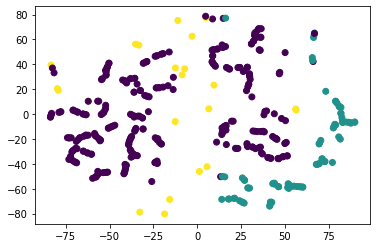

In [83]:
vis_2d_tsne_interactive(
    dataset = 'toy', 
    mode = 'true',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'inputs',
    y = 1
)

Loading the TSNE results...


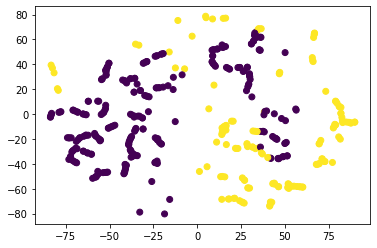

In [122]:
vis_2d_tsne_interactive(
    dataset = 'toy', 
    mode = 'pred',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'inputs',
    y = 1
)

Loading the TSNE results...


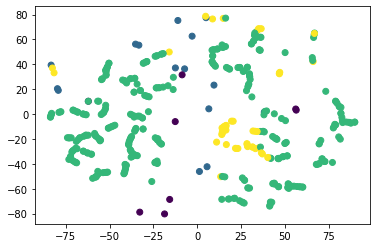

In [123]:
vis_2d_tsne_interactive(
    dataset = 'toy', 
    mode = 'acc',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'inputs',
    y = 1
)

Loading the TSNE results...


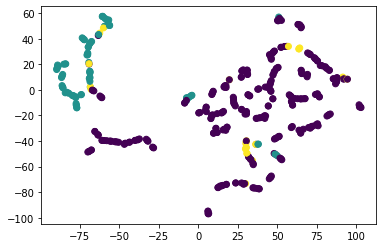

In [84]:
vis_2d_tsne_interactive(
    dataset = 'toy', 
    mode = 'true',
    outlier = 0,
    vis_group = true_group,
    vis_representation = 'grad',
    y = 1
)

Loading the TSNE results...


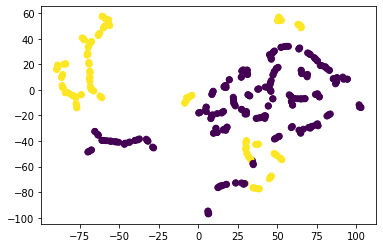

In [125]:
vis_2d_tsne_interactive(
    dataset = 'toy', 
    mode = 'pred',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'grad',
    y = 1
)

Loading the TSNE results...


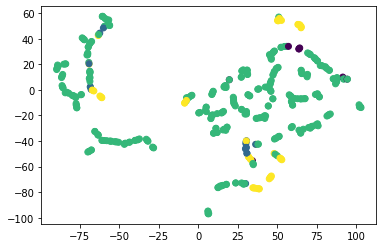

In [126]:
vis_2d_tsne_interactive(
    dataset = 'toy', 
    mode = 'acc',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'grad',
    y = 1
)

In [91]:
vis_3d_tsne_interactive(
    dataset = 'toy', 
    mode = 'acc',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'grad',
    y = 0
)

Loading the TSNE results...


In [92]:
vis_3d_tsne_interactive(
    dataset = 'toy', 
    mode = 'true',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'inputs',
    y = 0,
)

Loading the TSNE results...


In [86]:
vis_3d_tsne_interactive(
    dataset = 'toy', 
    mode = 'true',
    outlier = 1,
    vis_group = true_group,
    vis_representation = 'grad',
    y = 1,
)

Loading the TSNE results...


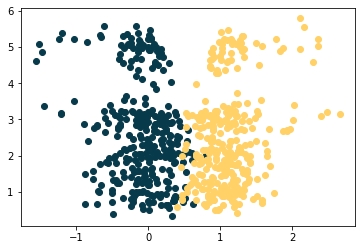

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
markers = ['o', 'x']
colors = [
    '#073B4C',
    '#FFD166',
    '#06D6A0',
    '#118AB2',
    '#DD3497',
]

for i in range(num_group):
    idx = pred_domain == i
    ax.scatter(inputs.T[0][idx], inputs.T[1][idx], color = colors[i])

In [164]:
(pred_domain[true_domain == 2] == -1).mean()

0.875

In [188]:
pred_domain, num_group = kmeans_results(inputs, use_val_group = 0)

Number of group: 2
Number of group: 4
ARS:  0.5323721212608802
SS:  0.15672729054298906


In [189]:
pred_domain, num_group = kmeans_results(grad, use_val_group = 0)

Number of group: 2
Number of group: 4
ARS:  0.8025534423673374
SS:  0.6048033


In [ ]:
ARS(true_domain[true_domain == 2], pred_domain[true_domain == 2])

# Waterbirds

In [164]:
dataset_name = 'waterbirds'

In [165]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    0,
    True,
    '%s/privateDemographics/models/waterbirds/erm_num_epoch_360_batch_size_128_lr_0.001_subsample_0_outlier_1_weight_decay_0.0001_best.model' % root_dir,
    123,
    'grass',
    torch.device('cpu'),
    1e-3,
    1e-5,
    '',
)


Representations are loaded from folder /mnt/cloud/yzeng58/privateDemographics/data/waterbirds_resnet50_outlier_0_representation!


In [166]:
grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 1
)

Loaded all the gradient information into folder /mnt/cloud/yzeng58/privateDemographics/results/waterbirds/outliers...


In [167]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    dataset_name,
    loader,
    device,
    m,
    num_domain,
    outlier = 1
)

Loaded all the input information into folder /mnt/cloud/yzeng58/privateDemographics/results/waterbirds/outliers...


In [168]:
dbscan_results(grad, process_grad=0, outlier=0, use_val_group=0)

0.3119631340314817 0.9441607
Number of group: 1
Best parameter:  {'eps': 0.7, 'min_samples': 5}
0.263803997687648 0.6654738
Number of group: 2
Best parameter:  {'eps': 0.7, 'min_samples': 5}
ARS:  0.7303645485247371
SS:  0.37668788


(array([0., 1., 0., ..., 0., 0., 0.]), 2)

In [169]:
dbscan_results(grad, process_grad=1, outlier=0, use_val_group=0, metric = 'cosine')

0.3722652724009311 0.938823
Number of group: 1
Best parameter:  {'eps': 0.25, 'min_samples': 50}
0.3309498583641263 0.78735757
Number of group: 2
Best parameter:  {'eps': 0.3, 'min_samples': 50}
ARS:  0.7453232323081922
SS:  0.48990357


(array([0., 1., 0., ..., 0., 0., 0.]), 2)

In [170]:
dbscan_results(inputs, process_grad=0, outlier=0, use_val_group=0)

0.0 -1
Number of group: 1
Best parameter:  {'eps': 0.1, 'min_samples': 5}
0.0 -1
Number of group: 0
Best parameter:  {'eps': 0.1, 'min_samples': 5}
ARS:  0.0
SS:  -1


(array([-1., -1., -1., ..., -1., -1., -1.]), 0)

In [171]:
dbscan_results(inputs, process_grad=1, outlier=0, use_val_group=0, metric = 'cosine')

-0.012427646716093659 0.003431991
Number of group: 1
Best parameter:  {'eps': 0.6, 'min_samples': 100}
0.0 -1
Number of group: 2
Best parameter:  {'eps': 0.6499999999999999, 'min_samples': 40}
ARS:  0.04181326931990819
SS:  -0.002442993


(array([-1., -1.,  0., ...,  0.,  0., -1.]), 2)

In [14]:
kmeans_results(inputs, use_val_group = 0)

Number of group: 2
Number of group: 4


(0.39315081175484157, 0.026123887)

In [15]:
kmeans_results(grad, use_val_group = 0)

Number of group: 2
Number of group: 4


(0.723520852802838, -0.15399548)

# Waterbirds w. outliers

In [8]:
dataset_name = 'waterbirds'

In [172]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    outlier = 1,
    load_representations = True,
    start_model_path = '%s/privateDemographics/models/waterbirds/erm_num_epoch_360_batch_size_128_lr_0.001_subsample_0_outlier_1_weight_decay_0.0001_best.model' % root_dir,
    seed = 123,
    method = 'grass',
    device = torch.device('cpu'),
    lr = 1e-3,
    weight_decay = 1e-5,
    model = '',
)


Get data from outlier folder!
Get data from outlier folder!
Get data from outlier folder!
Representations are loaded from folder /mnt/cloud/yzeng58/privateDemographics/data/waterbirds_resnet50_outlier_1_representation!


In [173]:
grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 1,
)

Loaded all the gradient information into folder /mnt/cloud/yzeng58/privateDemographics/results/waterbirds/outliers...


In [174]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    dataset_name,
    loader,
    device,
    m,
    num_domain,
    outlier = 1,
)

Loaded all the input information into folder /mnt/cloud/yzeng58/privateDemographics/results/waterbirds/outliers...


In [175]:
dbscan_results(grad, process_grad=0, outlier=0, use_val_group=0)

0.3119631340314817 0.9441607
Number of group: 1
Best parameter:  {'eps': 0.7, 'min_samples': 5}
0.263803997687648 0.6654738
Number of group: 2
Best parameter:  {'eps': 0.7, 'min_samples': 5}
ARS:  0.7303645485247371
SS:  0.37668788


(array([0., 1., 0., ..., 0., 0., 0.]), 2)

In [176]:
dbscan_results(grad, process_grad=1, outlier=0, use_val_group=0, metric = 'cosine')

0.3722652724009311 0.938823
Number of group: 1
Best parameter:  {'eps': 0.25, 'min_samples': 50}
0.3309498583641263 0.78735757
Number of group: 2
Best parameter:  {'eps': 0.3, 'min_samples': 50}
ARS:  0.7453232323081922
SS:  0.48990357


(array([0., 1., 0., ..., 0., 0., 0.]), 2)

In [177]:
dbscan_results(inputs, process_grad=0, outlier=0, use_val_group=0)

0.0 -1
Number of group: 1
Best parameter:  {'eps': 0.1, 'min_samples': 5}
0.0 -1
Number of group: 0
Best parameter:  {'eps': 0.1, 'min_samples': 5}
ARS:  0.0
SS:  -1


(array([-1., -1., -1., ..., -1., -1., -1.]), 0)

In [178]:
dbscan_results(inputs, process_grad=1, outlier=0, use_val_group=0, metric = 'cosine')

-0.012427646716093659 0.003431991
Number of group: 1
Best parameter:  {'eps': 0.6, 'min_samples': 100}
0.0 -1
Number of group: 2
Best parameter:  {'eps': 0.6499999999999999, 'min_samples': 40}
ARS:  0.04181326931990819
SS:  -0.002442993


(array([-1., -1.,  0., ...,  0.,  0., -1.]), 2)

In [14]:
kmeans_results(inputs, use_val_group = 0)

Number of group: 2
Number of group: 4


(0.39315081175484157, 0.026123887)

In [15]:
kmeans_results(grad, use_val_group = 0)

Number of group: 2
Number of group: 4


(0.7170896669457811, 0.48517329)

# COMPAS

In [4]:
dataset_name = 'compas'

In [5]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    outlier = 0,
    load_representations = True,
    start_model_path = '%s/privateDemographics/models/compas/erm_num_epoch_300_batch_size_128_lr_2e-05_subsample_0_outlier_0_weight_decay_0.001_best.model' % root_dir,
    seed = 123,
    method = 'grass',
    device = torch.device('cpu'),
    lr = 1e-3,
    weight_decay = 1e-5,
    model = '',
)


In [ ]:
grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 0
)

In [7]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    dataset_name,
    loader,
    device,
    m,
    num_domain,
    outlier = 0,
)

Loaded all the input information into folder /mnt/cloud/yzeng58/privateDemographics/results/compas...


In [ ]:
kmeans_results(inputs, use_val_group = 0)

In [ ]:
kmeans_results(grad, use_val_group = 0)

# Civilcomments

In [10]:
dataset_name = 'civilcomments'

In [11]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    outlier = 0,
    load_representations = True,
    start_model_path = '%s/privateDemographics/models/civilcomments/sgd_m_1_num_epoch_10_batch_size_32_lr_1e-05_optimizer_adam_subsample_0_weight_decay_0.01_best.model'  % root_dir,
    seed = 123,
    method = 'grass',
    device = torch.device('cpu'),
    lr = 1e-3,
    weight_decay = 1e-5,
    model = '',
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 0
)

Loaded all the gradient information into folder /mnt/cloud/yzeng58/privateDemographics/results/civilcomments...


In [13]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    dataset_name,
    loader,
    device,
    m,
    num_domain,
    outlier = 0,
)

Loaded all the input information into folder /mnt/cloud/yzeng58/privateDemographics/results/civilcomments...


In [20]:
kmeans_results(inputs.reshape(293316,660), use_val_group = 0)


KeyboardInterrupt



In [ ]:
kmeans_results(grad, use_val_group = 0)

In [191]:
np.array([
    [1,2,3],
    [1,2,3],
    [1,2,3]
])

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [197]:
a = np.random.rand(3,3,3)

In [198]:
a


array([[[0.22826323, 0.29371405, 0.63097612],
        [0.09210494, 0.43370117, 0.43086276],
        [0.4936851 , 0.42583029, 0.31226122]],

       [[0.42635131, 0.89338916, 0.94416002],
        [0.50183668, 0.62395295, 0.1156184 ],
        [0.31728548, 0.41482621, 0.86630916]],

       [[0.25045537, 0.48303426, 0.98555979],
        [0.51948512, 0.61289453, 0.12062867],
        [0.8263408 , 0.60306013, 0.54506801]]])

In [201]:
len(a.shape)

3